In [1]:
import sys
sys.path.extend([
    '../openml-python-OpenMLActiveClassificationTask/',
    '../openml-scikit-activeml/'
])

In [2]:
import numpy as np
from sklearn import ensemble
from openml.tasks import OpenMLActiveClassificationTask, TaskType
from openml import tasks, runs
from skactiveml.classifier import ParzenWindowClassifier
from skactiveml.pool import UncertaintySampling, RandomSampling, ProbabilisticAL
import openml
import openml_skactiveml
openml.config.start_using_configuration_for_example()

/home/tuan/Arbeit/openml-scikitactiveml/test_notebooks/../openml-python-OpenMLActiveClassificationTask/openml/config.py:184: UserWarning: Switching to the test server https://test.openml.org/api/v1/xml to not upload results to the live server. Using the test server may result in reduced performance of the API!
  warnings.warn(


In [3]:
task_id = 5199
task = tasks.get_task(task_id, download_data=False)

In [4]:
# # Example on how an AL task can be created from an existing classification task

# task_id = 1196
# task = tasks.get_task(task_id)

# my_task = openml.tasks.create_task(
#     task_type=TaskType.SUPERVISED_CLASSIFICATION,
#     dataset_id=128,
#     target_name="class",
#     evaluation_measure="predictive_accuracy",
#     estimation_procedure_id=1,
# )

# task = OpenMLActiveClassificationTask(
#         task_type_id=TaskType.ACTIVE_CLASSIFICATION,
#         task_type="ACTIVE_CLASSIFICATION",
#         data_set_id=task.dataset_id,
#         target_name=task.target_name,
#         class_labels=task.class_labels,
#         evaluation_measure="predictive_accuracy",
#         estimation_procedure_id=30, # 10-fold cross validation
#         annotation_costs=np.arange(150, dtype=float)*0+1, # hard-coded annotation cost for now
#         batch_size=1,
#     )

# task.publish()

In [5]:
task.batch_size

1

In [6]:
# model = {
#     'query_strategy':UncertaintySampling(missing_label=None),
#     'prediction_model':ParzenWindowClassifier(missing_label=None, classes=task.class_labels),
#     'query_params':{
#         "clf": ParzenWindowClassifier(missing_label=None, classes=task.class_labels)
#     },
#     'budget': 100000,
# }

model = {
    'query_strategy':ProbabilisticAL(missing_label=None),
    'prediction_model':ParzenWindowClassifier(missing_label=None, classes=task.class_labels),
    'query_params':{
        "clf": ParzenWindowClassifier(missing_label=None, classes=task.class_labels)
    },
    'budget': 100000,
}
# Automatically evaluate your model on the task
run = runs.run_model_on_task(model, task, upload_flow=False, avoid_duplicate_runs=False, n_jobs=1, seed=0)

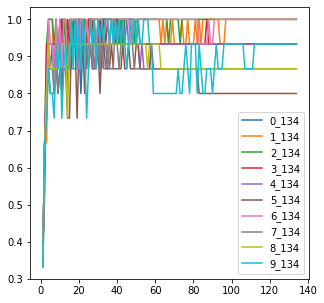

In [12]:
import matplotlib.pyplot as plt

X, y = task.get_X_and_y()

learning_curve_per_fold = []
budgets_per_fold = []

for repetition in range(1):
    for fold in range(10):
        fold_learning_curve = []
        preds = run.fold_evaluations['pred_t'][0][fold]
        budgets = run.fold_evaluations['budget_t'][0][fold]
        y_true_idx = task.get_train_test_split_indices(repeat=repetition, fold=fold)[1]
        y_true = np.array(task.class_labels)[y[y_true_idx]]
        for c in range(preds.shape[0]):
            fold_learning_curve.append(np.mean(preds[c,:] == y_true))
        learning_curve_per_fold.append(fold_learning_curve)
        budgets_per_fold.append(budgets)

for repetition in range(1):
    fig, ax = plt.subplots(1,1,figsize=(5,5))
    fig.set_facecolor('w')
    for fold in range(10):
        plt.plot(budgets_per_fold[fold] , learning_curve_per_fold[fold], label=f"{fold}_{len(learning_curve_per_fold[fold])}")
    # plt.plot(np.mean(learning_curve_per_fold, axis=0), label=str(fold))
    plt.legend()
    display(fig)
    plt.close(fig)

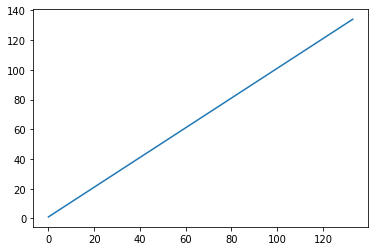

In [13]:
for budgets in [budgets_per_fold[0]]:
    plt.plot(budgets)

In [11]:
import arff
test_export = arff.dumps(run._generate_arff_dict())
with open('test_export.arff', 'w') as f:
    f.write(test_export)

In [14]:
run.to_filesystem('test_export')